In [1]:
import cv2
from keras import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Input , MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from keras.layers import Rescaling,Dropout
import numpy as np
import tensorflow as tf
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
from PIL import Image


class database():
    def __init__(self , path_face_classifier , path_IMAGE_DIR):
        self.face_classifier = cv2.CascadeClassifier(path_face_classifier)
        self.IMAGE_DIR = path_IMAGE_DIR

    def my_data(self , height , width ):

        x_train = []
        y_labels = []
        for root, directories, files in os.walk(self.IMAGE_DIR):

            for file in files:
                if file.endswith("png") or file.endswith("jpg") :
                    path = os.path.join(root, file)

                    label = os.path.basename(os.path.dirname(path))

                    image = cv2.imread(path)
                    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


                    faces = self.face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)



                    for x, y, w, h in faces:
                        rect_rgb = rgb[y:y + h, x:x + w]
                        rect_rgb = cv2.resize(rect_rgb, (height, width), interpolation=cv2.INTER_CUBIC)

                        x_train.append(rect_rgb)
                        y_labels.append(label)

        print("LFW data set created")

        return x_train , y_labels



In [9]:
# from ImageProcessing.colorFeret.colorFeret import colorFeret
# img_size = (384, 256)

# _ , x_images , y_labels , n = colorFeret().load_dataset(max_angle = 70 , root = "C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\colorFeret")
#


In [3]:
img_size = (100 ,100, 3)

face_classifier = "C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\haarcascade_frontalface_default.xml"
IMAGE_DIR = "C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Data\\Images"

x_images, y_labels = database(path_face_classifier=face_classifier , path_IMAGE_DIR = IMAGE_DIR).my_data( height=img_size[0],width=img_size[1])

len(x_images)


LFW data set created


680

In [4]:
def data_aug(x_images, y_labels , copy_number_per_image):
    data = []
    labels = []
    for i in range(len(x_images)):
        img = x_images[i]
        label = y_labels[i]

        for j in range(copy_number_per_image):

            img_ = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
            img_ = tf.image.stateless_random_contrast(img_, lower=0.6, upper=1, seed=(1,3))
            img_ = tf.image.stateless_random_flip_left_right(img_, seed=(np.random.randint(100),np.random.randint(100)))
            img_ = tf.image.stateless_random_jpeg_quality(img_, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
            img_ = tf.image.stateless_random_saturation(img_, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

            data.append(img_)
            labels.append(label)
    print(len(data), len(labels))
    return data , labels


2040 2040


C:\Users\bpk_e.EMRE\AppData\Local\Temp\ipykernel_21288\372962302.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if len(np.where(labels == y)[0]) >= min_number_of_images_exists_per_person * copy_number and len(np.where(np.array(Y_filtered) == y)[0]) <= max_number_of_images_per_person_in_dataset * copy_number:


2040
2040
['Akhilesh' 'Anna' 'Emmanuel' 'Emre_Karabulut' 'Gabrijel' 'Joshua' 'Lea']
7


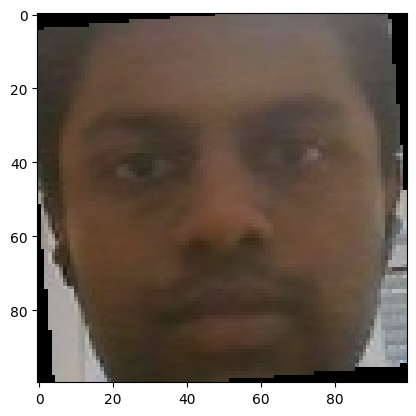

In [5]:
import random
from scipy import ndimage


# def hist_eq(img):
#
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     equalized = clahe.apply(img)
#     noisy = random_noise(equalized, mode='gaussian', clip=True,mean=0 ,var=1)
#     return noisy
# for im,label in zip(x_images, y_labels):
#     print(type(im), label)
copy_number = 3
X,Y = data_aug(x_images,y_labels , 3 )

X_filtered = []
Y_filtered = []

min_number_of_images_exists_per_person = 10
max_number_of_images_per_person_in_dataset = 1000

labels = np.array(Y)
for x , y  in zip(X,Y):
    if len(np.where(labels == y)[0]) >= min_number_of_images_exists_per_person * copy_number and len(np.where(np.array(Y_filtered) == y)[0]) <= max_number_of_images_per_person_in_dataset * copy_number:
        random_rotate_angle = random.randint(-5,5)
        random_flip_prob_threshold = 0.5
        if random.random() < random_flip_prob_threshold:
            x = np.flip(x , 1)
        x = ndimage.rotate(x, random_rotate_angle , reshape=False)
        X_filtered.append(x)
        Y_filtered.append(y)
print(len(X_filtered))
print(len(Y_filtered))
print(np.unique(Y_filtered))
n = len(np.unique(Y_filtered))
print(n)

plt.imshow(X_filtered[10] , cmap='gray')



In [6]:
encoder = LabelBinarizer()

Y_encoded = encoder.fit_transform(Y_filtered)
# for i , j in zip(Y_filtered,Y_encoded):
#     print(i , " - " , j)


X_train, X_test, Y_train, Y_test = train_test_split(X_filtered,Y_encoded,test_size = 0.2 , shuffle=True , stratify=Y_encoded)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size = 0.30 , shuffle=True, stratify=Y_train)


100
['Akhilesh' 'Anna' 'Emmanuel' 'Emre_Karabulut' 'Gabrijel' 'Joshua' 'Lea']


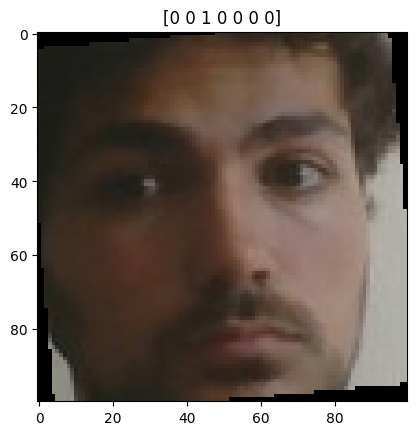

In [8]:
i = 100
print(i)
plt.title((Y_train[i]))
plt.imshow(X_train[i] , cmap="gray")
print(np.unique(Y_filtered))
#
# print("Data Created !!")
# print(type(X_train))
# print("Length of training set " , len(X_train) , len(Y_train))
# print("Length of validation set ",len(X_val), len(Y_val))
# print("Length of testing set ",len(X_test), len(Y_test))


In [9]:

input_image = Input(shape=(img_size[0],img_size[1], 3) , name='input')

c1 = Conv2D(20, (4,4), activation='relu')(input_image)
m1 = MaxPool2D((2,2))(c1)

c2 = Conv2D(40, (3,3), activation='relu')(m1)
m2 = MaxPool2D((2,2))(c2)

c3 = Conv2D(60, (3,3), activation='relu')(m2)
m3 = MaxPool2D((2,2))(c3)

c4 = Conv2D(80, (2,2), activation='sigmoid')(m3)

f1 = Flatten()(c4)

d1 = Dense(512 , activation='sigmoid')(f1)
dropout = Dropout(0.8)(d1)
output = Dense(n , activation='softmax')(dropout)

model = Model(inputs=[input_image], outputs=[output])


model.compile(optimizer='adam', loss= keras.losses.CategoricalCrossentropy(), metrics=keras.metrics.CategoricalAccuracy())

epoch = 100
batch_size =  256
patience = 20
callback = keras.callbacks.EarlyStopping(monitor='val_loss' , patience=patience, restore_best_weights=True  )
history = model.fit(np.array(X_train), np.array(Y_train), epochs=epoch, batch_size =batch_size,validation_data=( np.array(X_val),np.array(Y_val)) ,callbacks=[callback] , use_multiprocessing = True)
# history = model.fit(np.array(X_train), np.array(Y_train), epochs=100, batch_size = 64,validation_data=( np.array(X_val),np.array(Y_val)))

# history = model.fit(X_train, Y_train, epochs=epoch ,batch_size=batch_size, validation_data=( X_val,Y_val), callbacks=[callback] )
score, acc = model.evaluate(np.array(X_test), np.array(Y_test) )
print(score,acc)

Epoch 1/100
5/5 [==============================] - 16s 632ms/step - loss: 3.7823 - categorical_accuracy: 0.1515 - val_loss: 1.8870 - val_categorical_accuracy: 0.1469
Epoch 2/100
5/5 [==============================] - 1s 119ms/step - loss: 2.1025 - categorical_accuracy: 0.2636 - val_loss: 1.1868 - val_categorical_accuracy: 0.6878
Epoch 3/100
5/5 [==============================] - 0s 98ms/step - loss: 1.2125 - categorical_accuracy: 0.5455 - val_loss: 0.7111 - val_categorical_accuracy: 0.8388
Epoch 4/100
5/5 [==============================] - 0s 93ms/step - loss: 0.7345 - categorical_accuracy: 0.7469 - val_loss: 0.3012 - val_categorical_accuracy: 0.9796
Epoch 5/100
5/5 [==============================] - 0s 97ms/step - loss: 0.3657 - categorical_accuracy: 0.8940 - val_loss: 0.1243 - val_categorical_accuracy: 0.9837
Epoch 6/100
5/5 [==============================] - 0s 92ms/step - loss: 0.1752 - categorical_accuracy: 0.9676 - val_loss: 0.0571 - val_categorical_accuracy: 0.9898
Epoch 7/100
5

In [ ]:
import keras

model = Sequential()
model.add(Rescaling(1/255., input_shape=(img_size[0],img_size[1],3), name='input'))


model.add(Conv2D(32, (4, 4) , activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2) , strides=1))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Dropout(0.3))

# model.add(Conv2D(64, (3, 3), activation='relu'))



model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))


model.add(Dense(n, activation='softmax' , name='output'))

# dot_img_file = 'C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\colorFeret\\model.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
# opt = tf.keras.optimizers.experimental.SGD(0.05 )
# opt =  optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt =  optimizers.Adam(learning_rate=1e-4)
# opt =  optimizers.SGD(learning_rate=0.005, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer='adam', loss= keras.losses.CategoricalCrossentropy(), metrics=keras.metrics.CategoricalAccuracy())

epoch = 100
batch_size =  32
patience = 20
callback = keras.callbacks.EarlyStopping(monitor='val_loss' , patience=patience, restore_best_weights=True  )
history = model.fit(np.array(X_train), np.array(Y_train), epochs=epoch, batch_size =batch_size,validation_data=( np.array(X_val),np.array(Y_val)) ,callbacks=[callback] , use_multiprocessing = True)
# history = model.fit(np.array(X_train), np.array(Y_train), epochs=100, batch_size = 64,validation_data=( np.array(X_val),np.array(Y_val)))

# history = model.fit(X_train, Y_train, epochs=epoch ,batch_size=batch_size, validation_data=( X_val,Y_val), callbacks=[callback] )
score, acc = model.evaluate(np.array(X_test), np.array(Y_test) )
print(score,acc)



In [10]:
# Saved TF model path
print(model)
model.summary()
layer = model.get_layer('input')

print(layer.input)
# Directory to export new model

model.save("C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Model\\fr_model_3")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 97, 97, 20)        980       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 40)        7240      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 40)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 60)        21660 

INFO:tensorflow:Assets written to: C:\Users\bpk_e.EMRE\Desktop\PROJECTS\chatBotLastPhase\ImageProcessing\Model\fr_model_3\assets


INFO:tensorflow:Assets written to: C:\Users\bpk_e.EMRE\Desktop\PROJECTS\chatBotLastPhase\ImageProcessing\Model\fr_model_3\assets


In [11]:
# labels = np.flip(np.unique(Y_train,axis=0),1)

labels = np.unique(Y_filtered)
indices = range(0,len(labels))
dict_ = {indices[i]: labels[i] for i in range(len(labels))}

print(dict_)
import json
with open('C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBotLastPhase\\ImageProcessing\\Model\\labels.json', 'w') as f:
    json.dump(dict_, f)

{0: 'Akhilesh', 1: 'Anna', 2: 'Emmanuel', 3: 'Emre_Karabulut', 4: 'Gabrijel', 5: 'Joshua', 6: 'Lea'}


In [ ]:

# index = 14
# img = X_train[index]
# label_encoded = Y_train[index]
# label_index = np.where(label_encoded == 1 )[0]
# label = labels[label_index]
# print(label)
img = cv2.imread('C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\Data\\Images\\Emre_Karabulut\\Emre.1.jpg',0)
# img = hist_eq(img)
img = cv2.resize(img, img_size , cv2.INTER_AREA)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions * 100 )

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(predictions[0] )], 100 * np.max(predictions[0]))
)


In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['categorical_accuracy']
val_accuracy = history_dict['val_categorical_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, label='Training accuracy')
ax[0].plot(epochs, val_accuracy, label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, label='Training loss')
ax[1].plot(epochs, val_loss_values, label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()



In [ ]:
# reset_gpu_memory()

In [ ]:
# face_classifier = cv2.CascadeClassifier("C:\\Users\\bpk_e.EMRE\\Desktop\\PROJECTS\\chatBot\\ImageProcessing\\haarcascade_frontalface_default.xml")
# def face_cropped(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     faces = face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
#
#     if len(faces) == 0:
#         print("NO FACE DETECTED!!")
#         return None
#     for (x, y, w, h) in faces:
#         margin = 10
#         cropped_face = img[y-margin:y + h+margin, x-margin:x + w+margin]
#     return cropped_face
#
#
# def generate_dataset(name):
#     cap = cv2.VideoCapture(0)
#
#     img_id = 0
#     print("usao")
#     while True:
#         ret, frame = cap.read()
#         if face_cropped(frame) is not None:
#             img_id += 1
#             face = cv2.resize(face_cropped(frame), (224, 224))
#             face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
#
#             file_name_path = "Images\\" + name + "_" + str(img_id) + '.jpg'
#             cv2.imwrite(file_name_path, face)
#             # cv2.putText(face, str(img_id), (224, 224), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
#
#             cv2.imshow("Cropped_Face", face)
#             if cv2.waitKey(1) == 13 or int(img_id) == 100:
#                 break
#
#     cap.release()
#     cv2.destroyAllWindows()
#     print("Collecting samples is completed !!!")
# generate_dataset("emre")